# [`XLA.jl`](https://github.com/JuliaTPU/XLA.jl): Preprocessed ImageNet

We preprocess ImageNet into a giant, contiguous `(224, 224, 3, num_images)` tensor.  This is stored on disk in raw format so that our data loaders can simply `memmap()` the tensor into memory, and transmit it over the network to a waiting TPU.  We give here examples showing how the preprocessing was done, as well as what the preprocessed data looks like.

In [ ]:
# Activate our project
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Distributed, Images, Metalhead, Mmap, Printf

# Preprocessing

We start by defining a few helper methods to load an image, resize it, center-crop it, determine the ImageNet label index for that image, etc...  We include this code here rather than hide it away to demonstrate how simple it is to use general Julia packages to get something like a machine learning data processing pipeline up and running.

In [ ]:
# We're going to run distributed, so spin up #cpu's + 1 workers
println("Starting up $(Sys.CPU_THREADS+1) workers...")
workers = addprocs(Sys.CPU_THREADS+1)

# Load the ability to display and process images
@everywhere using Images, Metalhead, Mmap, Printf

In [ ]:
@everywhere function load_img(filename::AbstractString)
    # Load the image
    im = Images.load(filename)

    # Permute dimensions to WHC, return Float32 data
    return Float32.(permutedims(channelview(RGB.(im)), (2, 3, 1)))
end

@everywhere function resize_smallest_dimension(im::AbstractArray{T, 3}, len) where {T}
    reduction_factor = len/minimum(size(im)[1:2])
    new_size = (
        round(Int, size(im,1)*reduction_factor),
        round(Int, size(im,2)*reduction_factor),
        size(im, 3), # number of channels stays the same
    )
    
    if reduction_factor < 1.0
        # Use restrict() to quarter our size each step, which is much faster
        # than a single large Gaussian imfilter().
        while reduction_factor < 0.5
            # restrict() works on a single channel at a time, so squeeze each down,
            # then concatenate the three squeezed channels back into a single image.
            im = cat((restrict(im[:,:,cidx]) for cidx in 1:size(im, 3))..., dims=3)
            reduction_factor *= 2
        end
        
        # Build a lowpass filter to get rid of pesky high-frequency content that
        # will not be representable with the new spatial sampling rate
        im = imfilter(im, KernelFactors.gaussian(0.75/reduction_factor), Inner())
    end

    # Resize and return
    return imresize(im, new_size)
end

@everywhere function center_crop(im::AbstractArray{T, 3}, len::Integer) where {T}
    l2 = div(len,2)
    adjust = len % 2 == 0 ? 1 : 0
    return im[
        (div(end,2) - l2) : (div(end,2) + l2 - adjust),
        (div(end,2) - l2) : (div(end,2) + l2 - adjust),
        :, # across all channels
    ]
end

@everywhere function imagenet_data_loader(filename::String, target_size::Int = 224)
    # Load image file and preprocess it to get x
    x = load_img(filename)
    x = resize_smallest_dimension(x, round(Int,target_size*8/7))
    x = center_crop(x, target_size)

    # Quantize x to UInt8 for storage purposes
    x = round.(UInt8, x .* 255)

    # See if it's a `nXXXXX_*.JPEG` file:
    bfile = basename(filename)
    m = match(r"(n[\d]+)_", bfile)
    if m !== nothing
        # If it is, then the label is encoded in the filename (e.g. training data)
        label = m.captures[1]
    else
        # If it's not, then it's a validation filename, and grab the label from the
        # validation labels from Metalhead
        test_idx = parse(Int, split(splitext(bfile)[1], "_")[end])
        label = Metalhead.ImageNet.imagenet_val_labels[test_idx]
    end
    
    # Once we have the label, get the synset mapping index and return that with `x`.
    y = convert(UInt16, Metalhead.ImageNet.synset_mapping[label])
    return (x, y)
end

function recursive_readdir(root::String)
    ret = String[]
    for (r, dirs, files) in walkdir(root; follow_symlinks=true)
        for f in files
            push!(ret, joinpath(r, f)[length(root)+2:end])
        end
    end
    return ret
end

In [ ]:
# Next, get a list of all filenames:

# For the validation and training sets, find all images we're going to process, then process them!
for dataset in ("val", "train")
    # Find all jpeg files within this folder:
    dataset_root = "/home/sabae/ILSVRC/Data/CLS-LOC/$(dataset)"
    filenames = filter(f -> endswith(f, ".JPEG"), recursive_readdir(dataset_root))
    num_images = length(filenames)
    println("Processing $(num_images) images...")

    # Open the Mmap targets
    open("/home/sabae/ILSVRC/224/X_$(dataset).raw", "w+") do X_io
        open("/home/sabae/ILSVRC/224/Y_$(dataset).raw", "w+") do Y_io
            Xs = Mmap.mmap(X_io, Array{UInt8,4}, (224, 224, 3, num_images))
            Ys = Mmap.mmap(Y_io, Array{UInt16,1}, (num_images,))
            
            # For each filename, read it in, process it, then write it out.  We use pmap
            # so that it's much faster than it otherwise would be on a multicore machine.
            batch_size = 100
            for start_idx in 1:batch_size:num_images
                println(@sprintf("[%.1f%%: %d/%d]", start_idx*100.0/num_images, start_idx, num_images))
                
                idxs = start_idx:min(num_images, start_idx + 1000 - 1)
                vals = pmap(
                    imagenet_data_loader,
                    joinpath.(Ref(dataset_root), filenames[idxs]),
                    on_error = (f) -> (zeros(UInt8, 224, 224, 3), 1),
                )
                
                for (idx, (x, y)) in enumerate(vals)
                    Xs[:,:,:,start_idx + idx - 1] .= x
                    Ys[start_idx + idx - 1] = y
                end
            end
        end
    end
end

# Reading it back in

Let's make sure we can read it back in and see what terrors we have wrought:

In [2]:
num_images = 1281167
Xs = Mmap.mmap("/home/sabae/ILSVRC/224/X_train.raw", Array{UInt8,4}, (224, 224, 3, num_images))
println("memmap'ed $(num_images) 224x224x3 images")

memmap'ed 1281167 224x224x3 images


In [3]:
# Raw data view of the red channel of a guy holding a fish:
Xs[:, :, 1, 2]

224×224 Array{UInt8,2}:
 0x38  0x43  0x3d  0x30  0x50  0x6b  …  0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x2f  0x44  0x41  0x33  0x61  0x83     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x2a  0x2e  0x3a  0x48  0x69  0x80     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x2e  0x31  0x3e  0x50  0x65  0x75     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x3a  0x47  0x4d  0x4f  0x5a  0x66     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x33  0x37  0x36  0x33  0x3e  0x50  …  0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x31  0x27  0x21  0x1d  0x2a  0x41     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x57  0x30  0x2a  0x34  0x4b  0x5e     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x6d  0x40  0x3d  0x4e  0x6c  0x81     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x71  0x58  0x5b  0x6b  0x8b  0xac     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x80  0x71  0x69  0x64  0x7a  0x91  …  0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x8f  0x89  0x71  0x52  0x59  0x60     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 0x6b  0x8f  0x7c  0x4f  0x46  0x47     0xfe  0xfe  0xfe  0xfe  0xfe  0xfe
 

,,,,,,,,,

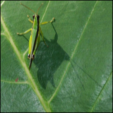
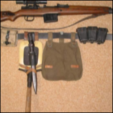
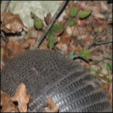
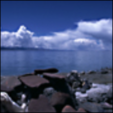
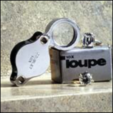
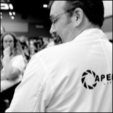
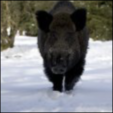
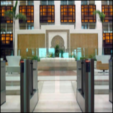
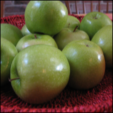
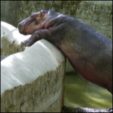

In [8]:
# Let's visualize a few of these images:
function extract_image(image_idx)
    colorview(RGB, permutedims(Xs[:, :, :, image_idx], (3, 1, 2))./255)
end

display([extract_image(rand(1:num_images)) for _ in 1:10])